In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from equationmodel_gp import gp_regression, prediction_rmse_error, gp_train_graph, gp_linear_compare_graph
from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph,\
                makeXforGraphWithGroupingSeason, train_2d_sigma_graph, train_2d_sigma_graph_s, groupWithFrequency

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

In [2]:
%autoreload

wt_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('season', 0.1), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('season', 0.1), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('season', 0.1), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sp_fileList = {'../data/PLdata_nonsan_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sm_fileList = {'../data/PLdata_nonsan_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}

addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

print("addWt")
print("antenna_b height filtering-before(data count):",addWt.shape)
addWt = filteringDF(addWt, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addWt.shape)

print("freespace pathloss filtering-before(data count):",addWt.shape)
addWt['freePathloss'] = getFreeSpacePathLoss(addWt['distance'],addWt['frequency'])
addWt = addWt[addWt['pathloss'] >= addWt['freePathloss']]
print("freespace pathloss filtering-after(data count):",addWt.shape)
#-------------------------------------------------------------------------------------------------
print("addSp")
print("antenna_b height filtering-before(data count):",addSp.shape)
addSp = filteringDF(addSp, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addSp.shape)

print("freespace pathloss filtering-before(data count):",addSp.shape)
addSp['freePathloss'] = getFreeSpacePathLoss(addSp['distance'],addSp['frequency'])
addSp = addSp[addSp['pathloss'] >= addSp['freePathloss']]
print("freespace pathloss filtering-after(data count):",addSp.shape)
#-------------------------------------------------------------------------------------------------
print("addIksanSm")
print("antenna_b height filtering-before(data count):",addSm.shape)
addSm = filteringDF(addSm, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addSm.shape)

print("freespace pathloss filtering-before(data count):",addSm.shape)
addSm['freePathloss'] = getFreeSpacePathLoss(addSm['distance'],addSm['frequency'])
addSm = addSm[addSm['pathloss'] >= addSm['freePathloss']]
print("freespace pathloss filtering-after(data count):",addSm.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_nonsan_wt_400.csv: distance filtering(before):(114545, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(after):(10209, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(before):(114341, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(after):(10209, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(before):(114455, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(after):(10209, 4)
         type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 416    m      1.01    111.36      0.02    0.10        400        30       15        2
     417    m      1.01    118.40      0.02    0.10        400        30       15        2
     418    m      1.01    112.88      0.02    0.10        400        30       15        2
     419    m      1.02    110.68      0.02    0.10        400        30       15        2
     420    m      1.03    109.04      0.02    0.10        400        30       15     

In [3]:
%autoreload

targetCols = ['logDistance', 'pathloss']
xCols = ['logDistance']
yCols = ['pathloss']

samplingRatio = 0.1
# addDataSample.sort_values(by=['logDistance'])
addWtSampled = samplingData(addWt[targetCols], samplingRatio, None)
addSpSampled = samplingData(addSp[targetCols], samplingRatio, None)
addSmSampled = samplingData(addSm[targetCols], samplingRatio, None)

stdDist = {0.1:list(), 0.5:list(), 1.0:list()}

data distribution(before)
       logDistance  pathloss
count     21802.00  21802.00
mean          0.26    133.17
std           0.09     14.12
min           0.00     90.19
25%           0.22    124.28
50%           0.30    133.04
75%           0.32    144.23
max           0.36    172.88
sampling shape(before):(21802, 2)
sampling shape(after):(2180, 2)
data distribution(after)
       logDistance  pathloss
count      2180.00   2180.00
mean          0.26    132.64
std           0.09     14.07
min           0.00     96.65
25%           0.22    123.28
50%           0.29    132.64
75%           0.33    143.63
max           0.36    170.64
data distribution(before)
       logDistance  pathloss
count      9174.00   9174.00
mean          0.24    132.85
std           0.10     14.01
min           0.00     86.40
25%           0.19    122.58
50%           0.27    134.42
75%           0.33    143.59
max           0.36    163.39
sampling shape(before):(9174, 2)
sampling shape(after):(917, 2)
data distr


Objective Function
std =  -0.39log_d +   3.31
Train STD Mean: 3.2053384987532527


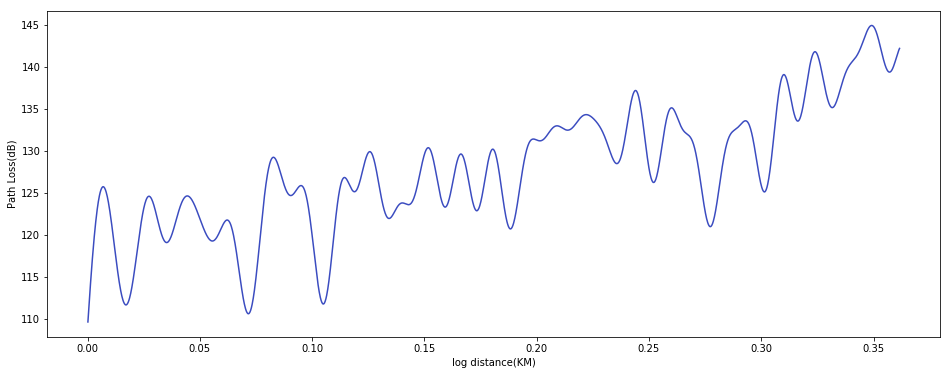

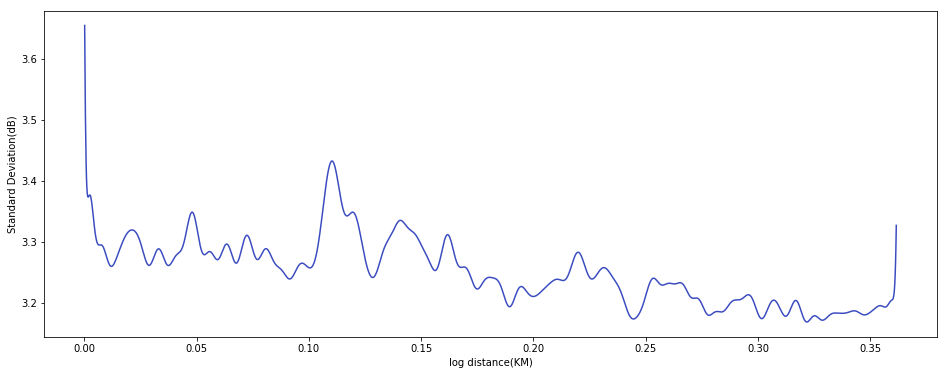

{0.1: [3.2053384987532527], 0.5: [], 1.0: []}


In [4]:
#### %autoreload

X = np.array(addWtSampled[xCols])
Y = np.array(addWtSampled[yCols])

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'

model = gp_regression(kernel)
model.fit(X, Y)
pred, std = model.predict(X, return_std=True)

linearModel = Ridge(alpha=0.0001)
linearModel.fit(X, std)
print("\nObjective Function")
print("std = {:6.2f}log_d + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))
    
meanSTD = stats.describe(std).mean
print("Train STD Mean: {}".format(meanSTD))
stdDist[0.1].append(meanSTD)

train_2d_sigma_graph_s(model, X, Y, targetCol = 'logDistance', sigmaFlag = False)   
train_2d_sigma_graph_s(model, X, Y)   

print(stdDist)


Objective Function
std =  -0.41log_d +   3.34
Train STD Mean: 3.2420230050146626


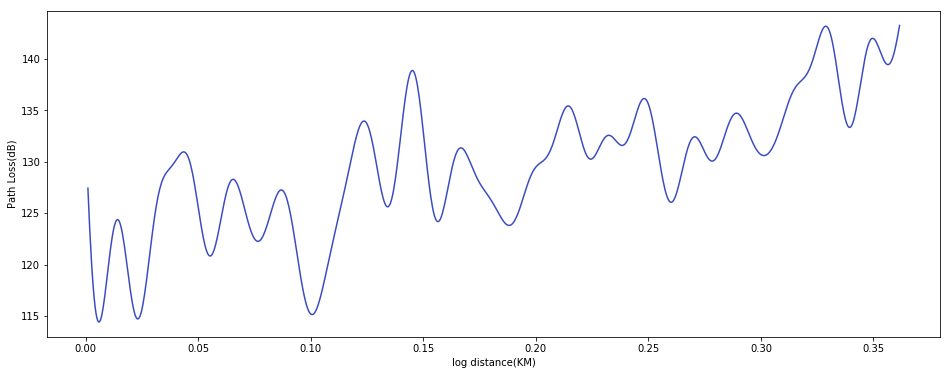

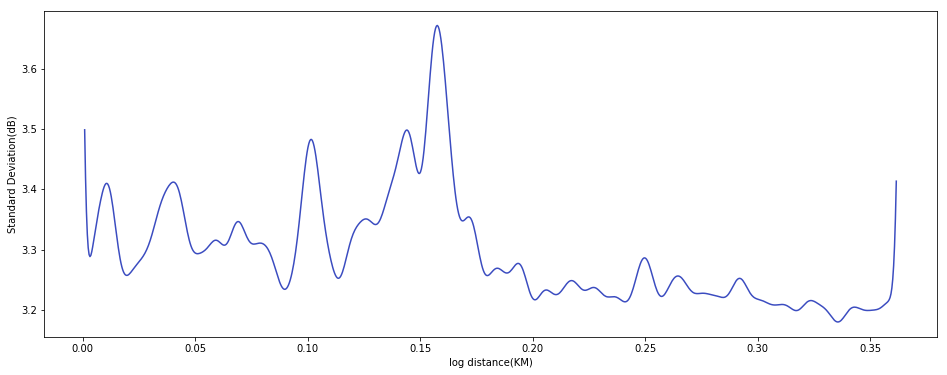

{0.1: [3.2053384987532527, 3.2420230050146626], 0.5: [], 1.0: []}


In [5]:
#### %autoreload

X = np.array(addSpSampled[xCols])
Y = np.array(addSpSampled[yCols])

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'

model = gp_regression(kernel)
model.fit(X, Y)

pred, std = model.predict(X, return_std=True)
linearModel = Ridge(alpha=0.0001)
linearModel.fit(X, std)
print("\nObjective Function")
print("std = {:6.2f}log_d + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))

meanSTD = stats.describe(std).mean
print("Train STD Mean: {}".format(meanSTD))
stdDist[0.1].append(meanSTD)

train_2d_sigma_graph_s(model, X, Y, targetCol = 'logDistance', sigmaFlag = False)   
train_2d_sigma_graph_s(model, X, Y)   

print(stdDist)


Objective Function
std =  -0.18log_d +   3.26
Train STD Mean: 3.219268947588161


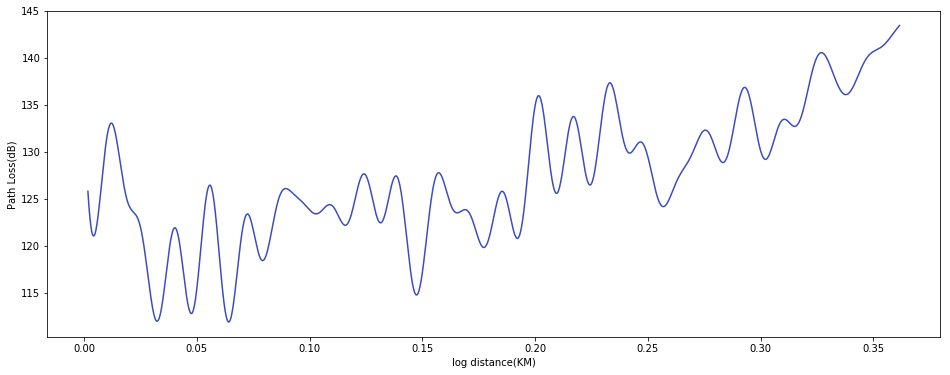

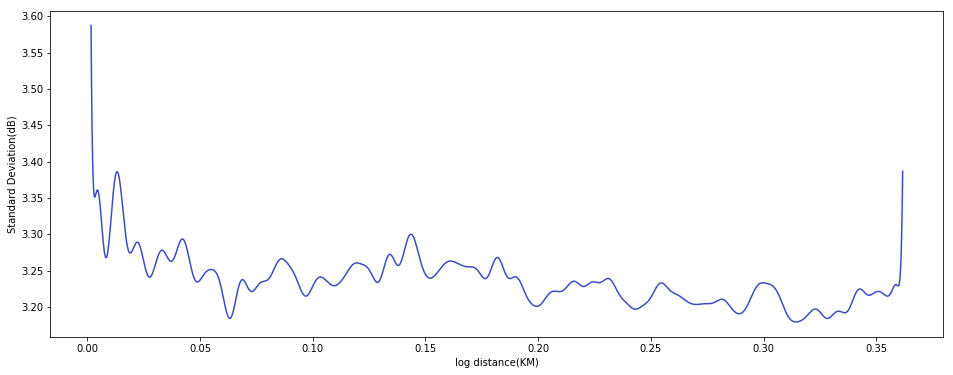

{0.1: [3.2053384987532527, 3.2420230050146626, 3.219268947588161], 0.5: [], 1.0: []}


In [6]:
#### %autoreload

X = np.array(addSmSampled[xCols])
Y = np.array(addSmSampled[yCols])

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'

model = gp_regression(kernel)
model.fit(X, Y)

pred, std = model.predict(X, return_std=True)
linearModel = Ridge(alpha=0.0001)
linearModel.fit(X, std)
print("\nObjective Function")
print("std = {:6.2f}log_d + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))

meanSTD = stats.describe(std).mean
print("Train STD Mean: {}".format(meanSTD))
stdDist[0.1].append(meanSTD)

train_2d_sigma_graph_s(model, X, Y, targetCol = 'logDistance', sigmaFlag = False)   
train_2d_sigma_graph_s(model, X, Y) 

print(stdDist)

In [7]:
print(stdDist)
STD = list()
for k,v in stdDist.items():
    for val in v:
        STD.append([k,val])
print(STD)
STDarray = np.array(STD)
X = STDarray[:,0]
Y = STDarray[:,1]
linearModel = Ridge(alpha=0.0001)
linearModel.fit(X.reshape(-1,1), Y.reshape(-1,1))

print("\nObjective Function")
print("STD = {:6.2f}s + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_)) 

{0.1: [3.2053384987532527, 3.2420230050146626, 3.219268947588161], 0.5: [], 1.0: []}
[[0.1, 3.2053384987532527], [0.1, 3.2420230050146626], [0.1, 3.219268947588161]]

Objective Function
STD =  -0.00s +   3.22


In [20]:
%autoreload

wt_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('season', 0.1), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('season', 0.1), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('season', 0.1), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sp_fileList = {'../data/PLdata_nonsan_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sm_fileList = {'../data/PLdata_nonsan_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}

addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

print("addWt")
print("antenna_b height filtering-before(data count):",addWt.shape)
addWt = filteringDF(addWt, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addWt.shape)

print("freespace pathloss filtering-before(data count):",addWt.shape)
addWt['freePathloss'] = getFreeSpacePathLoss(addWt['distance'],addWt['frequency'])
addWt = addWt[addWt['pathloss'] >= addWt['freePathloss']]
print("freespace pathloss filtering-after(data count):",addWt.shape)
#-------------------------------------------------------------------------------------------------
print("addSp")
print("antenna_b height filtering-before(data count):",addSp.shape)
addSp = filteringDF(addSp, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addSp.shape)

print("freespace pathloss filtering-before(data count):",addSp.shape)
addSp['freePathloss'] = getFreeSpacePathLoss(addSp['distance'],addSp['frequency'])
addSp = addSp[addSp['pathloss'] >= addSp['freePathloss']]
print("freespace pathloss filtering-after(data count):",addSp.shape)
#-------------------------------------------------------------------------------------------------
print("addIksanSm")
print("antenna_b height filtering-before(data count):",addSm.shape)
addSm = filteringDF(addSm, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addSm.shape)

print("freespace pathloss filtering-before(data count):",addSm.shape)
addSm['freePathloss'] = getFreeSpacePathLoss(addSm['distance'],addSm['frequency'])
addSm = addSm[addSm['pathloss'] >= addSm['freePathloss']]
print("freespace pathloss filtering-after(data count):",addSm.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_nonsan_wt_400.csv: distance filtering(before):(114545, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(after):(10209, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(before):(114341, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(after):(10209, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(before):(114455, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(after):(10209, 4)
         type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 416    m      1.01    111.36      0.02    0.10        400        30       15        2
     417    m      1.01    118.40      0.02    0.10        400        30       15        2
     418    m      1.01    112.88      0.02    0.10        400        30       15        2
     419    m      1.02    110.68      0.02    0.10        400        30       15        2
     420    m      1.03    109.04      0.02    0.10        400        30       15     

In [21]:
%autoreload

targetCols = ['extendedHeightTratio', 'pathloss']
xCols = ['extendedHeightTratio']
yCols = ['pathloss']

samplingRatio = 0.1
# addDataSample.sort_values(by=['logDistance'])
addWtSampled = samplingData(addWt[targetCols], samplingRatio, None)
addSpSampled = samplingData(addSp[targetCols], samplingRatio, None)
addSmSampled = samplingData(addSm[targetCols], samplingRatio, None)

stdDist = {0.1:list(), 0.5:list(), 1.0:list()}

data distribution(before)
       extendedHeightTratio  pathloss
count              21802.00  21802.00
mean                   0.61    133.17
std                    0.22     14.12
min                    0.27     90.19
25%                    0.43    124.28
50%                    0.60    133.04
75%                    0.74    144.23
max                    2.23    172.88
sampling shape(before):(21802, 2)
sampling shape(after):(2180, 2)
data distribution(after)
       extendedHeightTratio  pathloss
count               2180.00   2180.00
mean                   0.61    132.64
std                    0.22     14.07
min                    0.27     96.65
25%                    0.43    123.28
50%                    0.60    132.64
75%                    0.74    143.63
max                    1.84    170.64
data distribution(before)
       extendedHeightTratio  pathloss
count               9174.00   9174.00
mean                   0.69    132.85
std                    0.29     14.01
min                  


Objective Function
std =   0.32|log_(hb1/hm1)| +   3.06
Train STD Mean: 3.2582654207687174


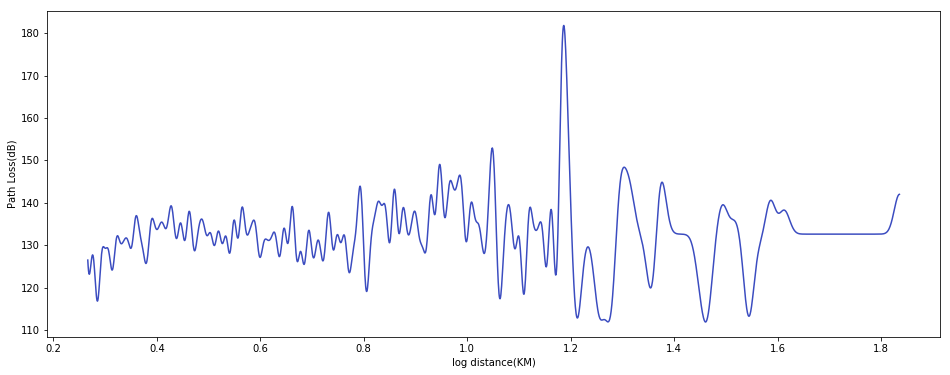

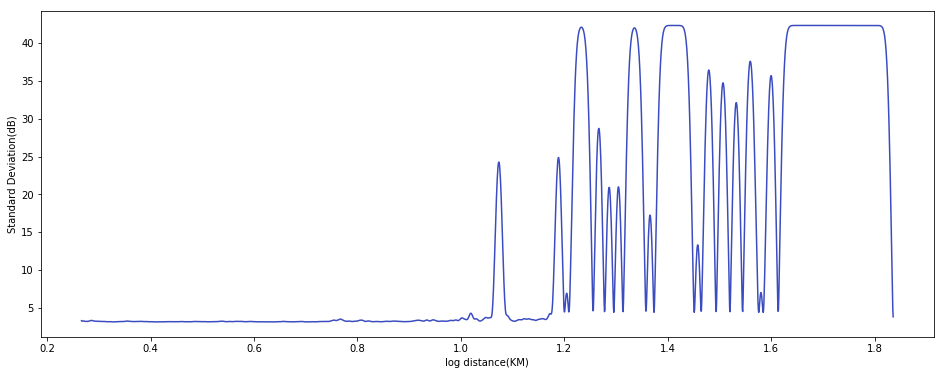

{0.1: [3.2582654207687174], 0.5: [], 1.0: []}


In [22]:
#### %autoreload

X = np.array(addWtSampled[xCols])
Y = np.array(addWtSampled[yCols])

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'

model = gp_regression(kernel)
model.fit(X, Y)
pred, std = model.predict(X, return_std=True)

linearModel = Ridge(alpha=0.0001)
linearModel.fit(X, std)
print("\nObjective Function")
print("std = {:6.2f}|log_(hb1/hm1)| + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))
    
meanSTD = stats.describe(std).mean
print("Train STD Mean: {}".format(meanSTD))
stdDist[0.1].append(meanSTD)

train_2d_sigma_graph_s(model, X, Y, targetCol = 'extendedHeightTratio', sigmaFlag = False)   
train_2d_sigma_graph_s(model, X, Y, targetCol = 'extendedHeightTratio', sigmaFlag = True)   

print(stdDist)


Objective Function
std =   0.00|log_(hb1/hm1)| +   3.16
Train STD Mean: 3.1622792398582713


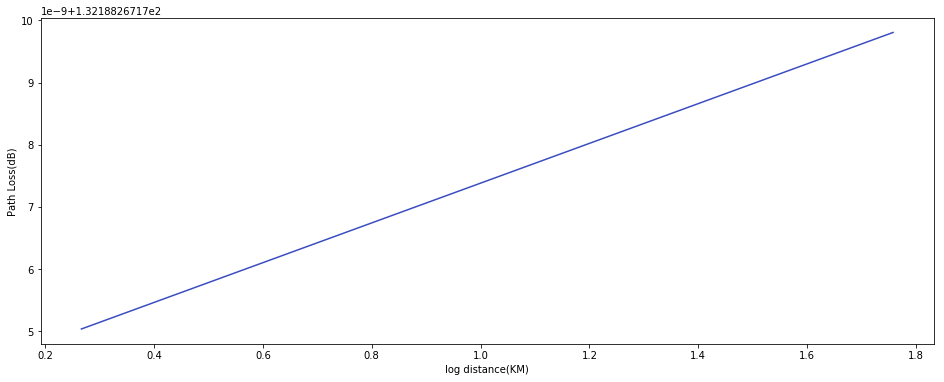

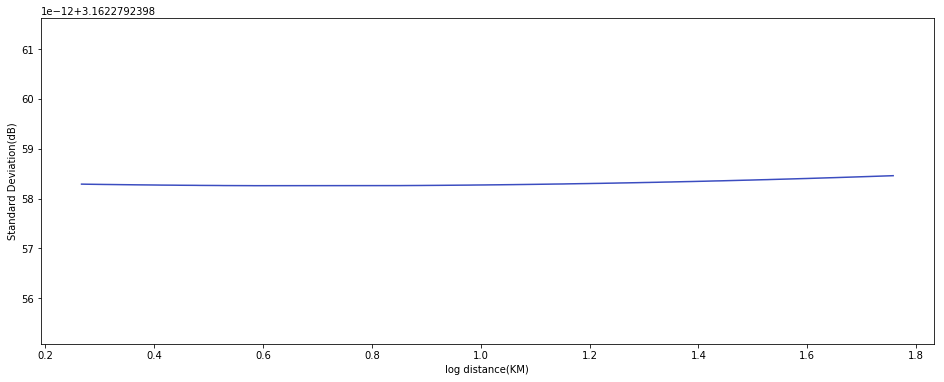

{0.1: [3.2582654207687174], 0.5: [3.1622792398582713], 1.0: []}


In [23]:
#### %autoreload

X = np.array(addSpSampled[xCols])
Y = np.array(addSpSampled[yCols])

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'

model = gp_regression(kernel)
model.fit(X, Y)

pred, std = model.predict(X, return_std=True)
linearModel = Ridge(alpha=0.0001)
linearModel.fit(X, std)
print("\nObjective Function")
print("std = {:6.2f}|log_(hb1/hm1)| + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))

meanSTD = stats.describe(std).mean
print("Train STD Mean: {}".format(meanSTD))
stdDist[0.5].append(meanSTD)

train_2d_sigma_graph_s(model, X, Y, targetCol = 'extendedHeightTratio', sigmaFlag = False)   
train_2d_sigma_graph_s(model, X, Y, targetCol = 'extendedHeightTratio', sigmaFlag = True)   

print(stdDist)


Objective Function
std =   0.25|log_(hb1/hm1)| +   3.15
Train STD Mean: 3.3381539118837162


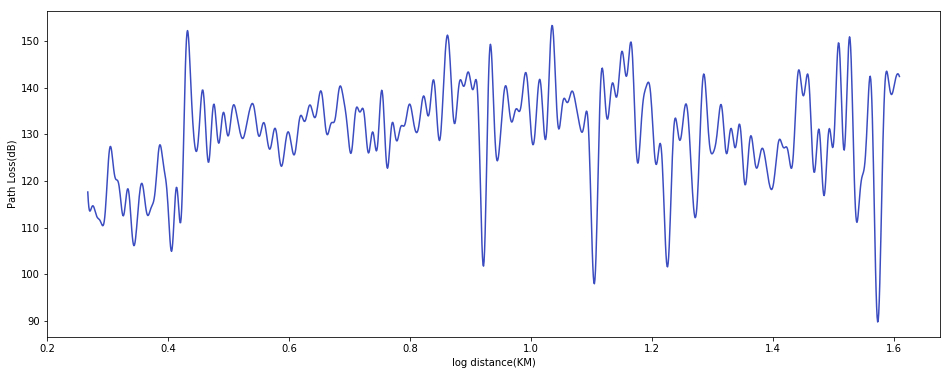

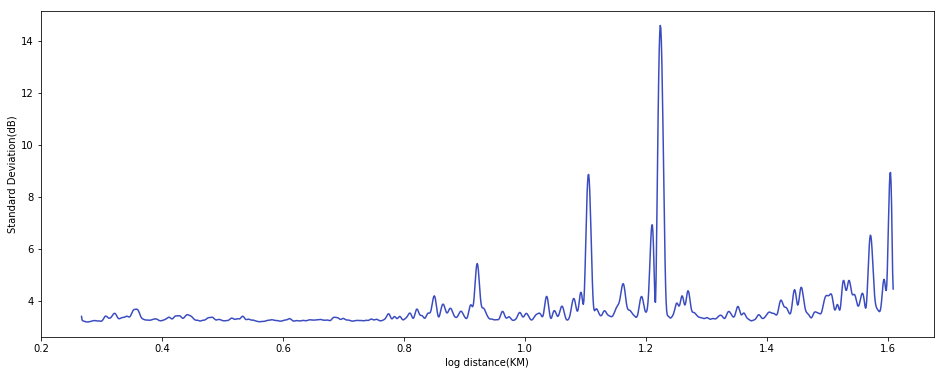

{0.1: [3.2582654207687174], 0.5: [3.1622792398582713], 1.0: [3.3381539118837162]}


In [24]:
#### %autoreload

X = np.array(addSmSampled[xCols])
Y = np.array(addSmSampled[yCols])

modelList = []
dataSet = []
i = 1

stdTrainSum, stdTestSum = 0, 0
kernel = 'RBF'

model = gp_regression(kernel)
model.fit(X, Y)

pred, std = model.predict(X, return_std=True)
linearModel = Ridge(alpha=0.0001)
linearModel.fit(X, std)
print("\nObjective Function")
print("std = {:6.2f}|log_(hb1/hm1)| + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_))

meanSTD = stats.describe(std).mean
print("Train STD Mean: {}".format(meanSTD))
stdDist[1.0].append(meanSTD)

train_2d_sigma_graph_s(model, X, Y, targetCol = 'extendedHeightTratio', sigmaFlag = False)   
train_2d_sigma_graph_s(model, X, Y, targetCol = 'extendedHeightTratio', sigmaFlag = True)   

print(stdDist)

In [25]:
print(stdDist)
STD = list()
for k,v in stdDist.items():
    for val in v:
        STD.append([k,val])
print(STD)
STDarray = np.array(STD)
X = STDarray[:,0]
Y = STDarray[:,1]
linearModel = Ridge(alpha=0.0001)
linearModel.fit(X.reshape(-1,1), Y.reshape(-1,1))

print("\nObjective Function")
print("STD = {:6.2f}|log_(hb1/hm1)| + {:6.2f}".format(linearModel.coef_[0],linearModel.intercept_)) 

{0.1: [3.2582654207687174], 0.5: [3.1622792398582713], 1.0: [3.3381539118837162]}
[[0.1, 3.2582654207687174], [0.5, 3.1622792398582713], [1.0, 3.3381539118837162]]

Objective Function
STD =   0.10|log_(hb1/hm1)| +   3.20
